In [56]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import konlpy
import pandas as pd
import os
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import sentencepiece as spm
from collections import Counter

print(torch.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(konlpy.__version__)

device = torch.device("mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# data path
train_data = pd.read_table(os.getenv("HOME") + '/Desktop/going_deeper_project/nsmc/ratings_train.txt')
test_data = pd.read_table(os.getenv("HOME") + '/Desktop/going_deeper_project/nsmc/ratings_test.txt')

train_data.head()

2.9.1
2.3.4
3.10.7
0.6.0
Using device: mps


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [57]:
def preprocess_data(data):
    data.drop_duplicates(subset=['document'], inplace=True)
    data = data.dropna(how='any')
    return data

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)
print(len(train_data),len(test_data))

146182 49157


In [58]:
LSTM_HIDDEN_DIM = 16
CNN_OUT_CHANNELS = 16
OUTPUT_DIM = 1

In [59]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, hidden_dim, output_dim, padding_idx):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(word_vector_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, output_dim)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = h_n[-1]
        x = self.fc1(x); x = self.relu(x); x = self.fc2(x); x = self.sigmoid(x)
        return x.squeeze()

class CNN(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, out_channels, output_dim, padding_idx):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim, padding_idx=padding_idx)
        self.conv1 = nn.Conv1d(word_vector_dim, out_channels, kernel_size=7)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=7)
        self.pool = nn.MaxPool1d(5)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(out_channels, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, output_dim)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.embedding(x); x = x.permute(0, 2, 1)
        x = self.conv1(x); x = self.relu(x); x = self.pool(x)
        x = self.conv2(x); x = self.relu(x)
        x = self.global_max_pooling(x); x = x.view(x.size(0), -1)
        x = self.fc1(x); x = self.relu(x); x = self.fc2(x); x = self.sigmoid(x)
        return x.squeeze()

In [60]:
criterion = nn.BCELoss()

In [61]:
def calculate_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        epoch_loss, epoch_acc = 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = calculate_accuracy(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
        train_loss = epoch_loss / len(train_loader)
        train_acc = epoch_acc / len(train_loader)
        
        model.eval()
        epoch_val_loss, epoch_val_acc = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                val_acc = calculate_accuracy(outputs, labels)
                epoch_val_loss += val_loss.item()
                epoch_val_acc += val_acc.item()
                
        val_loss = epoch_val_loss / len(val_loader)
        val_acc = epoch_val_acc / len(val_loader)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1:02}/{num_epochs} | Time: {time.time()-start_time:.2f}s")
        print(f"\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        print(f"\tVal. Loss: {val_loss:.4f} | Val. Acc: {val_acc*100:.2f}%")
        
    return history

# [cell 50]의 train_model 함수 아래에 이어서 추가하세요.

def evaluate_model(model, test_loader, criterion, device):
    """
    학습이 완료된 모델을 테스트 데이터로 평가하는 함수
    """
    model.eval()  # 평가 모드
    
    epoch_test_loss, epoch_test_acc = 0, 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            acc = calculate_accuracy(outputs, labels)  # 기존에 정의된 함수 사용
            
            epoch_test_loss += loss.item()
            epoch_test_acc += acc.item()
            
    test_loss = epoch_test_loss / len(test_loader)
    test_acc = epoch_test_acc / len(test_loader)
    
    return test_loss, test_acc

all_histories = {} #saving results

In [62]:
#tokenizer hyperparameters
MAX_LEN = 60       
PAD_INDEX = 0      
BATCH_SIZE = 64
NUM_EPOCHS = 7
LEARNING_RATE = 1e-3

In [63]:
#sentencepiece 
EMBEDDING_DIM_SP = 128
VOCAB_SIZE_SP = 10000  

temp_file = 'nsmc_train_corpus.txt'
with open(temp_file, 'w', encoding='utf-8') as f:
    for row in train_data['document']:
        f.write(str(row) + '\n')

sp_model_prefix = 'nsmc_spm'
spm.SentencePieceTrainer.Train(
    f'--input={temp_file} --model_prefix={sp_model_prefix} --vocab_size={VOCAB_SIZE_SP} '
    '--model_type=unigram --max_sentence_length=9999'
)

def sp_tokenize(s, corpus, max_len, padding_idx):
    
    tensor = []
    for sen in corpus:
        # Encode 후 MAX_LEN에 맞게 자르기
        encoded = s.EncodeAsIds(sen)
        if len(encoded) > max_len:
            encoded = encoded[:max_len]
        tensor.append(torch.tensor(encoded, dtype=torch.long))

    word_index = {}
    index_word = {}
    
    pad_token = 0 
    unk_token_sp = 0 
    
    word_index['<PAD>'] = pad_token
    index_word[pad_token] = '<PAD>'
    
    with open(f"{sp_model_prefix}.vocab", 'r', encoding='utf-8') as f:
        vocab = f.readlines()

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        current_idx = idx # SP가 부여한 인덱스
        
        if current_idx == unk_token_sp: # 0번 인덱스(<unk>) 충돌 방지
            new_idx = 3 # ''(UNK)와 유사하게 3번 부여
            word_index[word] = new_idx
            index_word[new_idx] = word
        elif current_idx > pad_token: # 1(<s>), 2(</s>) 등
            if word not in word_index: # 중복 방지
                word_index[word] = current_idx
                index_word[current_idx] = word

    tensor_padded = pad_sequence(tensor, batch_first=True, padding_value=padding_idx)
    return tensor_padded, word_index, index_word

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=nsmc_train_corpus.txt --model_prefix=nsmc_spm --vocab_size=10000 --model_type=unigram --max_sentence_length=9999
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: nsmc_train_corpus.txt
  input_format: 
  model_prefix: nsmc_spm
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 9999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vo

In [64]:
s = spm.SentencePieceProcessor()
s.Load(f'{sp_model_prefix}.model')

X_train_sp_pad, word_to_index_sp, index_word_sp = sp_tokenize(s, train_data['document'], MAX_LEN, PAD_INDEX)
X_test_sp_pad, _, _ = sp_tokenize(s, test_data['document'], MAX_LEN, PAD_INDEX)

y_train_sp_tensor = torch.tensor(train_data['label'].values, dtype=torch.float32)
y_test_sp_tensor = torch.tensor(test_data['label'].values, dtype=torch.float32)

# 4.5. SP 데이터로더 생성
X_train_t_sp, X_val_t_sp, y_train_t_sp, y_val_t_sp = train_test_split(
    X_train_sp_pad, y_train_sp_tensor, test_size=0.2, random_state=42
)

train_loader_sp = DataLoader(TensorDataset(X_train_t_sp, y_train_t_sp), batch_size=BATCH_SIZE, shuffle=True)
val_loader_sp = DataLoader(TensorDataset(X_val_t_sp, y_val_t_sp), batch_size=BATCH_SIZE, shuffle=False)
test_loader_sp = DataLoader(TensorDataset(X_test_sp_pad, y_test_sp_tensor), batch_size=BATCH_SIZE, shuffle=False)

# 4.6. SP 모델 학습 (사전 크기를 SP에 맞게 조절)
VOCAB_SIZE_SP_ACTUAL = len(word_to_index_sp)
print(f"SentencePiece 실제 사전 크기: {VOCAB_SIZE_SP_ACTUAL}")

histories_sp = {}
for model_name, ModelClass, dim in [
    ("LSTM", LSTM, LSTM_HIDDEN_DIM), 
    ("CNN", CNN, CNN_OUT_CHANNELS)]:
    print(f"\nTraining SentencePiece - {model_name}...")
    if model_name == "GlobalPool":
        model = ModelClass(VOCAB_SIZE_SP_ACTUAL, EMBEDDING_DIM_SP, OUTPUT_DIM, PAD_INDEX).to(device)
    else:
        model = ModelClass(VOCAB_SIZE_SP_ACTUAL, EMBEDDING_DIM_SP, dim, OUTPUT_DIM, PAD_INDEX).to(device)
        
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    history = train_model(model, train_loader_sp, val_loader_sp, optimizer, criterion, NUM_EPOCHS, device)
    histories_sp[model_name] = history

    test_loss, test_acc = evaluate_model(model, test_loader_sp, criterion, device) 
    print(f"\tTest Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

    

all_histories["SentencePiece"] = histories_sp
print("\n--- SentencePiece Experiment Complete ---")

SentencePiece 실제 사전 크기: 10001

Training SentencePiece - LSTM...
Epoch 01/7 | Time: 41.04s
	Train Loss: 0.6931 | Train Acc: 50.16%
	Val. Loss: 0.6927 | Val. Acc: 50.54%
Epoch 02/7 | Time: 38.89s
	Train Loss: 0.6901 | Train Acc: 51.16%
	Val. Loss: 0.6377 | Val. Acc: 66.56%
Epoch 03/7 | Time: 46.52s
	Train Loss: 0.4702 | Train Acc: 78.22%
	Val. Loss: 0.4038 | Val. Acc: 82.16%
Epoch 04/7 | Time: 20.98s
	Train Loss: 0.3397 | Train Acc: 85.64%
	Val. Loss: 0.3797 | Val. Acc: 83.78%
Epoch 05/7 | Time: 20.66s
	Train Loss: 0.2867 | Train Acc: 88.35%
	Val. Loss: 0.3781 | Val. Acc: 84.10%
Epoch 06/7 | Time: 20.17s
	Train Loss: 0.2488 | Train Acc: 90.14%
	Val. Loss: 0.3951 | Val. Acc: 83.77%
Epoch 07/7 | Time: 20.03s
	Train Loss: 0.2180 | Train Acc: 91.62%
	Val. Loss: 0.4002 | Val. Acc: 83.92%
	Test Loss: 0.4046 | Test Acc: 83.51%

Training SentencePiece - CNN...
Epoch 01/7 | Time: 13.86s
	Train Loss: 0.4953 | Train Acc: 74.95%
	Val. Loss: 0.3985 | Val. Acc: 81.93%
Epoch 02/7 | Time: 14.34s
	Train 


센텐스피스 모델 결과


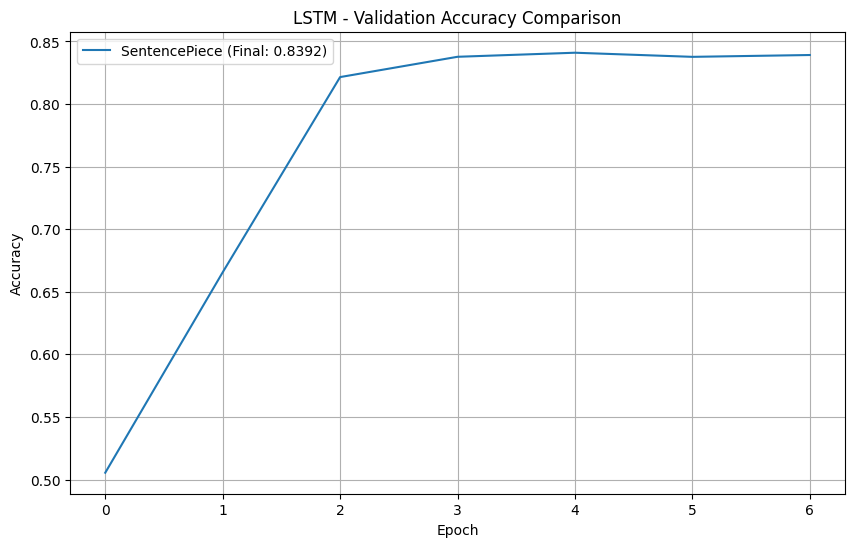

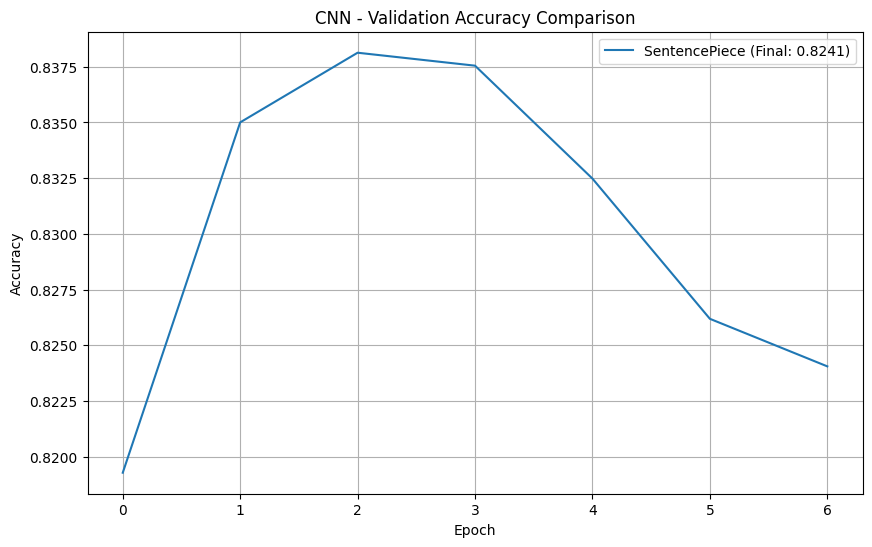

In [65]:
#setencepiece 결과
print("\n센텐스피스 모델 결과")

def plot_comparison(model_name, all_histories):
    plt.figure(figsize=(10, 6))
    
    for exp_name, histories in all_histories.items():
        if model_name in histories:
            # 마지막 epoch의 validation accuracy를 레이블에 추가
            final_acc = histories[model_name]['val_acc'][-1]
            plt.plot(histories[model_name]['val_acc'], label=f'{exp_name} (Final: {final_acc:.4f})')
    
    plt.title(f'{model_name} - Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# 3개 모델에 대해 비교 그래프 출력
model_names_to_compare = ["LSTM", "CNN"]
for model_name in model_names_to_compare:
    if any(model_name in h for h in all_histories.values()):
        plot_comparison(model_name, all_histories)
    else:
        print(f"'{model_name}'에 대한 학습 결과가 없어 비교 그래프를 그릴 수 없습니다.")

#아래는 Mecab

In [66]:
print("\n Mecab")

from konlpy.tag import Mecab
from collections import Counter

# 5.1. Mecab Hyperparameters
VOCAB_SIZE_MECAB = 10000
EMBEDDING_DIM_MECAB = 128  # SentencePiece와 동일하게 128로 설정
UNK_INDEX_MECAB = 3       # <UNK> 인덱스 (SP와 동일하게 3으로 설정)

# 5.2. Build Mecab Vocabulary (from train_data)
print("Building Mecab vocabulary...")
try:
    tokenizer = Mecab()
except NameError:
    print("Mecab이 초기화되지 않았습니다. Colab 환경이라면 런타임 재시작이 필요할 수 있습니다.")
    # Colab에서 위 설치 셀 실행 후, '런타임 > 런타임 다시 시작'이 필요합니다.
    tokenizer = Mecab()

counter = Counter()
for sentence in train_data['document']:
    counter.update(tokenizer.morphs(str(sentence)))

# Vocab size, leaving room for PAD and UNK
vocab_words = counter.most_common(VOCAB_SIZE_MECAB - 2)

word_to_index_mecab = {}
word_to_index_mecab['<PAD>'] = PAD_INDEX         # 0
word_to_index_mecab['<UNK>'] = UNK_INDEX_MECAB   # 3

index_to_word_mecab = {PAD_INDEX: '<PAD>', UNK_INDEX_MECAB: '<UNK>'}

idx = 4  # 0(PAD), 3(UNK) 외의 인덱스 시작
for word, _ in vocab_words:
    if word not in word_to_index_mecab:
        word_to_index_mecab[word] = idx
        index_to_word_mecab[idx] = word
        idx += 1

VOCAB_SIZE_MECAB_ACTUAL = len(word_to_index_mecab)
print(f"Mecab 실제 사전 크기: {VOCAB_SIZE_MECAB_ACTUAL}")

# 5.3. Mecab Tokenizer Function
def mecab_tokenize_pad(corpus, max_len, padding_idx, unk_idx):
    tokenizer = Mecab()
    tensor = []
    for sen in corpus:
        morphs = tokenizer.morphs(str(sen))
        if len(morphs) > max_len:
            morphs = morphs[:max_len] # Truncate
        
        indexed = [word_to_index_mecab.get(word, unk_idx) for word in morphs]
        tensor.append(torch.tensor(indexed, dtype=torch.long))
    
    tensor_padded = pad_sequence(tensor, batch_first=True, padding_value=padding_idx)
    return tensor_padded

# 5.4. Tokenize and create tensors
print("Tokenizing data with Mecab...")
X_train_mecab_pad = mecab_tokenize_pad(train_data['document'], MAX_LEN, PAD_INDEX, UNK_INDEX_MECAB)
X_test_mecab_pad = mecab_tokenize_pad(test_data['document'], MAX_LEN, PAD_INDEX, UNK_INDEX_MECAB)

y_train_mecab_tensor = torch.tensor(train_data['label'].values, dtype=torch.float32)
y_test_mecab_tensor = torch.tensor(test_data['label'].values, dtype=torch.float32)

# 5.5. Create DataLoaders
X_train_t_mecab, X_val_t_mecab, y_train_t_mecab, y_val_t_mecab = train_test_split(
    X_train_mecab_pad, y_train_mecab_tensor, test_size=0.2, random_state=42
)

train_loader_mecab = DataLoader(TensorDataset(X_train_t_mecab, y_train_t_mecab), batch_size=BATCH_SIZE, shuffle=True)
val_loader_mecab = DataLoader(TensorDataset(X_val_t_mecab, y_val_t_mecab), batch_size=BATCH_SIZE, shuffle=False)
test_loader_mecab= DataLoader(TensorDataset(X_test_mecab_pad, y_test_mecab_tensor), batch_size=BATCH_SIZE, shuffle=False)
# 5.6. Train Mecab Models
histories_mecab = {}
for model_name, ModelClass, dim in [
    ("LSTM", LSTM, LSTM_HIDDEN_DIM), 
    ("CNN", CNN, CNN_OUT_CHANNELS)]:
    
    print(f"\nTraining Mecab - {model_name}...")
    model = ModelClass(VOCAB_SIZE_MECAB_ACTUAL, EMBEDDING_DIM_MECAB, dim, OUTPUT_DIM, PAD_INDEX).to(device)
        
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    history = train_model(model, train_loader_mecab, val_loader_mecab, optimizer, criterion, NUM_EPOCHS, device)
    histories_mecab[model_name] = history
    test_loss, test_acc = evaluate_model(model, test_loader_mecab, criterion, device)
    print(f"\tTest Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
# 5.7. Save results
all_histories["Mecab"] = histories_mecab
print("\n--- Mecab Experiment Complete ---")


 Mecab
Building Mecab vocabulary...
Mecab 실제 사전 크기: 10000
Tokenizing data with Mecab...

Training Mecab - LSTM...
Epoch 01/7 | Time: 20.11s
	Train Loss: 0.6931 | Train Acc: 50.20%
	Val. Loss: 0.6764 | Val. Acc: 61.34%
Epoch 02/7 | Time: 21.49s
	Train Loss: 0.6696 | Train Acc: 57.61%
	Val. Loss: 0.6914 | Val. Acc: 50.64%
Epoch 03/7 | Time: 20.74s
	Train Loss: 0.6571 | Train Acc: 59.80%
	Val. Loss: 0.6337 | Val. Acc: 65.67%
Epoch 04/7 | Time: 20.75s
	Train Loss: 0.6192 | Train Acc: 67.09%
	Val. Loss: 0.6009 | Val. Acc: 70.47%
Epoch 05/7 | Time: 20.81s
	Train Loss: 0.5592 | Train Acc: 72.46%
	Val. Loss: 0.5309 | Val. Acc: 74.86%
Epoch 06/7 | Time: 20.13s
	Train Loss: 0.4539 | Train Acc: 79.58%
	Val. Loss: 0.4195 | Val. Acc: 81.93%
Epoch 07/7 | Time: 19.59s
	Train Loss: 0.3602 | Train Acc: 84.58%
	Val. Loss: 0.3757 | Val. Acc: 83.72%
	Test Loss: 0.3805 | Test Acc: 83.45%

Training Mecab - CNN...
Epoch 01/7 | Time: 13.89s
	Train Loss: 0.4442 | Train Acc: 78.64%
	Val. Loss: 0.3791 | Val. Ac